# Estimation of level sets with BoTorch

following the entry level tutorial here https://botorch.org but I have also browsed extensively along Bite-sized and full-loop tutorials

## 1. Low dimension / low data (no fancy sampling)

Problem in 1-d: $f_{BlackBox}(x) = 2*sin(x) - x$ at threshold $t=3.$

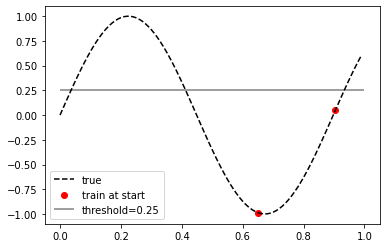

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import Tensor
from botorch.utils import standardize

def f(x: Tensor):
    return torch.sin(7*x)
    
t = 0.25

#generate truth data
true_x = torch.arange(0, 1, 0.01).double()
true_y = f(true_x).double()

#generate std training data
train_x = torch.rand(2,1).double()
train_y = f(train_x).double()
train_y_std = standardize(train_y).double()
noise = torch.full_like(train_y, 0.)
#plot
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.hlines(t, 0, 1, color='grey', label=f'threshold={t}');
plt.legend();

In [2]:
#train model 
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

gp = FixedNoiseGP(train_x, train_y, noise);
mll = ExactMarginalLogLikelihood(gp.likelihood, gp);
fit_gpytorch_model(mll);

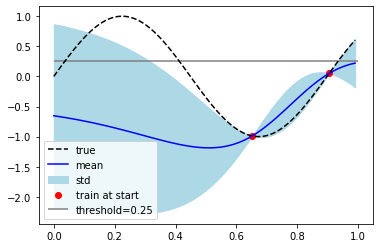

In [3]:
#plot fit
import numpy as np
mean = gp.posterior(true_x).mean.detach().numpy().flatten()
std = np.sqrt(gp.posterior(true_x).variance.detach().numpy().flatten())
plt.plot(true_x, true_y, color='black', linestyle='--', label='true');
plt.plot(true_x, mean, color='blue', label='mean');
plt.fill_between(true_x, mean-std, mean+std, color='lightblue', label='std');
plt.scatter(train_x, train_y, color='red', marker='o', label='train at start')
plt.hlines(0.25, 0, 1, color='grey', label='threshold=0.25');
plt.legend();


In [4]:
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition.objective import ScalarizedObjective
from botorch.models.model import Model
from typing import Optional
import numpy as np
import math

def cdf(mu, sigma, t):
    #DEBUG: use torch.erfc for numerical stability?
    erf = torch.erf((t - mu) * sigma.reciprocal() / math.sqrt(2))
    cdf = 0.5 * (1 + erf)
    return cdf.double()

class MaximumEntropySearch(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        thresholds: list,
        objective: Optional[ScalarizedObjective] = None,
        maximize: bool = True,
    ) -> None:
          
        super().__init__(model=model, objective=objective)
        self.maximize = maximize
        self.thr = thresholds
        self.thresholds = [-np.inf] + thresholds + [np.inf] #add -inf and inf as thresholds
        self.entropy = torch.Tensor([0.])

    def forward(self, X: Tensor):
        # DEBUG: dirty code ahead
        print(f"###### X {X}")
        posterior = self._get_posterior(X=X)
        batch_shape = X.shape[:-2]
        mean = posterior.mean.view(batch_shape).double()
        std = torch.square(posterior.variance.view(batch_shape).double())
        
        #init entropy
        #entropy = torch.zeros_like(mean, requires_grad=True).double()
        
        for t in self.thr:
            p_j = cdf(mean, std, t)
            
            #p_j.requires_grad = True
            print(f"p_j {p_j}")
            probs_j = torch.Tensor([p_j, 1-p_j]).double()
            print(f"probs_j {probs_j}")
            distr_j = torch.distributions.Categorical(probs_j)
            print(f"distr_j {distr_j}")
            entropy_j = distr_j.entropy().view(-1)
            print(f"entropy_j {entropy_j}")
            print(f"type entropy_j {type(entropy_j)}")
            print(f"size entropy_j {entropy_j.shape}")
        #loop over pairs of consecutive thresholds
        #for j in range(len(self.thresholds) - 1):
        #    print(f"###### {self.thresholds[j + 1]}, {self.thresholds[j]}")
        #    
        #    #tensor of probability that each point's image is below the threshold under posterior of GP 
        #    p_j = cdf(mean, std, self.thresholds[j + 1]) - \
        #          cdf(mean, std, self.thresholds[j])
        #    print(f"p_j {p_j}")
        #    #entropy update
        #    entropy[p_j > 0] -= torch.log(
        #        torch.exp(p_j[p_j > 0])
        #    ) * torch.log(torch.exp(torch.log(p_j[p_j > 0])))

        return entropy_j

In [5]:
MES = MaximumEntropySearch(gp, thresholds=[t])

In [6]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(1), torch.ones(1)])
bounds = bounds.double()

candidate, acq_value = optimize_acqf(
    MES, bounds=bounds, q=1, num_restarts=1, raw_samples=1,
)


print(f"candidate {candidate} acq_value {acq_value}")

p_j tensor([1.], dtype=torch.float64)
probs_j tensor([1., 0.], dtype=torch.float64)
distr_j Categorical(probs: torch.Size([2]))
entropy_j tensor([[2.2204e-16]], dtype=torch.float64)
type entropy_j <class 'torch.Tensor'>
size entropy_j torch.Size([1, 1])
p_j tensor([1.], dtype=torch.float64, grad_fn=<MulBackward0>)
probs_j tensor([1., 0.], dtype=torch.float64)
distr_j Categorical(probs: torch.Size([2]))
entropy_j tensor([[2.2204e-16]], dtype=torch.float64)
type entropy_j <class 'torch.Tensor'>
size entropy_j torch.Size([1, 1])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn